In [1]:
# @title Importing dependencies
import numpy
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [12]:
mnist_train = torchvision.datasets.MNIST('/home/stuti/fods/files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor()
                            ]))
mnist_test = torchvision.datasets.MNIST('/home/stuti/fods/files/', train=False, download=True,
                            transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor()
                            ]))

In [ ]:
# # @title Binarise MNIST data
# def binarise_mnist(mnist):
#     mnist_bin = []
#     for img, label in mnist:
#         mnist_bin.append((torch.where(img < 0.5, 0.0, 1.0), label))
#     return mnist_bin

In [ ]:
# X_train = binarise_mnist(mnist_train)
# X_test = binarise_mnist(mnist_test)

In [13]:
class CroppedConvolution2D(nn.Module):  # cropped conv class - just crops and upsamples output of conv
    def __init__(self, in_channels: int, out_channels: int, kernel_size: tuple, padding: tuple):
        super(CroppedConvolution2D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_height, self.kernel_width = kernel_size
        self.padding = padding
        self.conv = nn.Conv2d(self.in_channels, self.out_channels, kernel_size, padding=self.padding)

    def forward(self, X):
        X = self.conv(X)
        out = X[:, :, 1:-self.kernel_height, :]
        up_shifted_out = X[:, :, :-self.kernel_height-1, :]
        return out, up_shifted_out

In [3]:
class MaskedConvolution2D(nn.Module):   # masked conv - same as pixelcnn
    def __init__(self, in_channels: int, out_channels: int, kernel_size: tuple, padding: tuple, mask_type: str):
        super(MaskedConvolution2D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_height, self.kernel_width = kernel_size
        self.padding = padding
        self.mask_type = mask_type
        self.conv = nn.Conv2d(self.in_channels, self.out_channels, kernel_size, padding=self.padding)
        self.create_mask()

    def create_mask(self):
        mask = torch.ones(self.kernel_height, self.kernel_width)
        mask[self.kernel_height // 2, self.kernel_width // 2:] = 0
        mask[self.kernel_height // 2 + 1:, :] = 0
        if self.mask_type == 'B':
            mask[self.kernel_height // 2, self.kernel_width // 2] = 1
        self.register_buffer('mask', mask)

    def forward(self, X):
        self.conv.weight.data = self.conv.weight.data * self.mask   # return masked kernel weights
        return self.conv(X)

In [4]:
class CausalBlock(nn.Module):   # no skip connections in the causal block
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int):
        super(CausalBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        self.vertical_fc = nn.Conv2d(in_channels=in_channels,
                                     out_channels=2*out_channels,
                                     kernel_size=(1, 1))

        self.vertical_conv = CroppedConvolution2D(in_channels=in_channels,
                                                  out_channels=2*out_channels,
                                                  kernel_size=(kernel_size // 2 + 1, kernel_size),
                                                  padding=(kernel_size // 2 + 1, kernel_size // 2))

        self.vertical_to_horizontal = nn.Conv2d(in_channels=2*out_channels,
                                                out_channels=2*out_channels,
                                                kernel_size=(1, 1))

        self.horizontal_conv = MaskedConvolution2D(in_channels=in_channels,
                                                   out_channels=2*out_channels,
                                                   kernel_size=(1, kernel_size),
                                                   padding=(0, kernel_size // 2),
                                                   mask_type='A')

        self.horizontal_fc = MaskedConvolution2D(in_channels=out_channels,
                                                 out_channels=out_channels,
                                                 kernel_size=(1, 1),
                                                 padding=(0, 0),
                                                 mask_type='A')

    def forward(self, X):
        out_vertical_fc = self.vertical_fc(X)
        out_vertical_conv, up_shifted_out_vertical_conv = self.vertical_conv(X)
        out_vertical_to_horizontal = self.vertical_to_horizontal(up_shifted_out_vertical_conv)
        out_vertical = out_vertical_fc + out_vertical_conv
        out_vertical_tanh, out_vertical_sigmoid = torch.split(out_vertical, self.out_channels, dim=1)   # split feature maps and apply activations
        out_vertical = torch.tanh(out_vertical_tanh) * torch.sigmoid(out_vertical_sigmoid)

        out_horizontal_conv = self.horizontal_conv(X)
        out_horizontal = out_horizontal_conv + out_vertical_to_horizontal
        out_horizontal_tanh, out_horizontal_sigmoid = torch.split(out_horizontal, self.out_channels, dim=1)
        out_horizontal = torch.tanh(out_horizontal_tanh) * torch.sigmoid(out_horizontal_sigmoid)
        out_horizontal = self.horizontal_fc(out_horizontal)

        return out_vertical, out_horizontal

In [5]:
class GatedBlock(nn.Module):    # gated blocks used for skip connection outputs
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, latent_dim: int=16):
        super(GatedBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.latent_dim = latent_dim

        self.vertical_fc = nn.Conv2d(in_channels=in_channels,
                                     out_channels=2*out_channels,
                                     kernel_size=(1, 1))

        self.vertical_to_horizontal = MaskedConvolution2D(in_channels=2*out_channels,
                                                          out_channels=2*out_channels,
                                                          kernel_size=(1, 1),
                                                          padding=(0, 0),
                                                          mask_type='B')

        self.vertical_conv = CroppedConvolution2D(in_channels=in_channels,
                                                  out_channels=2*out_channels,
                                                  kernel_size=(kernel_size // 2 + 1, kernel_size),
                                                  padding=(kernel_size // 2 + 1, kernel_size // 2))

        self.horizontal_conv = MaskedConvolution2D(in_channels=in_channels,
                                                   out_channels=2*out_channels,
                                                   kernel_size=(1, kernel_size),
                                                   padding=(0, kernel_size // 2),
                                                   mask_type='B')

        self.horizontal_fc = MaskedConvolution2D(in_channels=out_channels,
                                                 out_channels=out_channels,
                                                 kernel_size=(1, 1),
                                                 padding=(0, 0),
                                                 mask_type='B')

        self.horizontal_skip = MaskedConvolution2D(in_channels=out_channels,
                                                 out_channels=out_channels,
                                                 kernel_size=(1, 1),
                                                 padding=(0, 0),
                                                 mask_type='B')

        self.latent_embedding = nn.Linear(in_features=latent_dim, out_features=2*out_channels)
        self.label_embedding = nn.Embedding(10, 2*out_channels)

    def forward(self, X):
        # get info from prev block
        in_vertical, in_horizontal, label, latent, skip = X['in_vertical'], X['in_horizontal'], X['label'], X['latent'], X['skip']
        latent_embedding = self.latent_embedding(latent).unsqueeze(2).unsqueeze(3)
        label_embedding = self.label_embedding(label).unsqueeze(2).unsqueeze(3)

        out_vertical_fc = self.vertical_fc(in_vertical)
        out_vertical_conv, up_shifted_out_vertical_conv = self.vertical_conv(in_vertical)
        out_vertical_to_horizontal = self.vertical_to_horizontal(up_shifted_out_vertical_conv)
        out_vertical = out_vertical_fc + out_vertical_conv + latent_embedding + label_embedding # add label embedding!
        out_vertical_tanh, out_vertical_sigmoid = torch.split(out_vertical, self.out_channels, dim=1)   #split feature maps
        out_vertical = torch.tanh(out_vertical_tanh) * torch.sigmoid(out_vertical_sigmoid)
        out_vertical += in_vertical

        out_horizontal_conv = self.horizontal_conv(in_horizontal)
        out_horizontal = out_horizontal_conv + out_vertical_to_horizontal + latent_embedding + label_embedding
        out_horizontal_tanh, out_horizontal_sigmoid = torch.split(out_horizontal, self.out_channels, dim=1)
        out_horizontal = torch.tanh(out_horizontal_tanh) * torch.sigmoid(out_horizontal_sigmoid)
        skip += self.horizontal_skip(out_horizontal)
        out_horizontal = self.horizontal_fc(out_horizontal)
        out_horizontal += in_horizontal

        return {'in_vertical': out_vertical,
                'in_horizontal': out_horizontal,
                'label': label,
                'latent': latent,
                'skip': skip}   # return skip connections

In [6]:
class ConditionalGate(nn.Module):   # conditional gate used to split feature maps and apply activations like in causal and gated blocks
    def __init__(self, latent_dim: int, out_channels: int=32):
        super(ConditionalGate, self).__init__()
        self.latent_dim = latent_dim
        self.out_channels = out_channels

        self.latent_embedding_tanh = nn.Linear(in_features=latent_dim, out_features=out_channels)
        self.latent_embedding_sigmoid = nn.Linear(in_features=latent_dim, out_features=out_channels)
        self.label_embedding_tanh = nn.Embedding(10, out_channels)
        self.label_embedding_sigmoid = nn.Embedding(10, out_channels)

    def forward(self, X, label, latent_var):
        out_tanh, out_sigmoid = torch.split(X, self.out_channels, dim=1)

        latent_embedding_tanh = self.latent_embedding_tanh(latent_var).unsqueeze(2).unsqueeze(3)
        label_embedding_tanh = self.label_embedding_tanh(label).unsqueeze(2).unsqueeze(3)
        latent_embedding_sigmoid = self.latent_embedding_sigmoid(latent_var).unsqueeze(2).unsqueeze(3)
        label_embedding_sigmoid = self.label_embedding_sigmoid(label).unsqueeze(2).unsqueeze(3)

        out_tanh = out_tanh + latent_embedding_tanh + label_embedding_tanh  # add label embedding!
        out_sigmoid = out_sigmoid + latent_embedding_sigmoid + label_embedding_sigmoid
        out = torch.tanh(out_tanh) * torch.sigmoid(out_sigmoid)
        return out

In [7]:
class Encoder(nn.Module):   # encoder is a bunch of convs
    def __init__(self, in_channels: int, latent_dim: int):
        super(Encoder, self).__init__()
        self.in_channels = in_channels
        self.latent_dim = latent_dim

        layers = []
        layers.append(nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding='same'))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding='same'))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.ZeroPad2d((0, 1, 0,1)))  # Pad 7x7 feature maps to 8x8
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same'))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1))
        layers.append(nn.ReLU())
        for _ in range(3):
            layers.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same'))
            layers.append(nn.ReLU())
        layers.append(nn.Flatten())
        layers.append(nn.Linear(in_features=1024, out_features=2*latent_dim))
        self.net = nn.Sequential(*layers)
        self.label_embedding = nn.Embedding(10, in_channels)

    def reparameterise(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, X, label):
        label_embedding = self.label_embedding(label).unsqueeze(2).unsqueeze(3)
        out = X + label_embedding
        out = self.net(out)
        mu, logvar = torch.split(out, self.latent_dim, dim=1)
        z = self.reparameterise(mu, logvar)
        return mu, logvar, z

In [8]:
class ConditionalDecoder(nn.Module):    # uses conditional gates
    def __init__(self, latent_dim: int, in_channels: int=1, hidden_layers: int=5):
        super(ConditionalDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.in_channels = in_channels
        self.hidden_layers = hidden_layers

        self.causal_block = CausalBlock(in_channels=in_channels, out_channels=latent_dim, kernel_size=7)
        self.gated_blocks = nn.Sequential(
            *[GatedBlock(in_channels=latent_dim, out_channels=latent_dim, kernel_size=5, latent_dim=latent_dim) for _ in range(hidden_layers)]
        )
        self.label_embedding = nn.Embedding(10, latent_dim)
        self.conv_1 = nn.Conv2d(in_channels=latent_dim, out_channels=2*latent_dim, kernel_size=(1, 1))
        self.conditional_gate_1 = ConditionalGate(latent_dim=latent_dim, out_channels=latent_dim)
        self.conv_2 = nn.Conv2d(in_channels=latent_dim, out_channels=2*latent_dim, kernel_size=(1, 1))
        self.conditional_gate_2 = ConditionalGate(latent_dim=latent_dim, out_channels=latent_dim)
        self.conv_3 = nn.Conv2d(in_channels=latent_dim, out_channels=4*in_channels, kernel_size=(1, 1))

    def forward(self, X, label, latent_var):
        out_vertical, out_horizontal = self.causal_block(X)
        out = self.gated_blocks({'in_vertical': out_vertical,
                                 'in_horizontal': out_horizontal,
                                 'label': label,    # pass label embedding to gated blocks
                                 'latent': latent_var,
                                 'skip': X.new_zeros(X.size()[0], self.latent_dim, X.size()[2], X.size()[3])})['in_horizontal']
        out = self.conv_1(out)
        out = self.conditional_gate_1(out, label, latent_var)
        out = self.conv_2(out)
        out = self.conditional_gate_2(out, label, latent_var)
        out = self.conv_3(out)
        return out

In [9]:
class ConditionalPixelVAE(nn.Module):   # final model class
    def __init__(self, in_channels: int, latent_dim: int=32, hidden_layers: int=5):
        super(ConditionalPixelVAE, self).__init__()
        self.encoder = Encoder(in_channels=in_channels,
                               latent_dim=latent_dim)
        self.decoder = ConditionalDecoder(latent_dim=latent_dim,
                                          in_channels=in_channels,
                                          hidden_layers=hidden_layers)

    def sample(self, image_size=(28, 28), num_samples=1, labels=None, device='cpu'):
        self.eval()

        H, W = image_size
        C = self.decoder.in_channels

        # 1) Sample z ~ N(0, I)
        z = torch.randn(num_samples, self.encoder.latent_dim, device=device)

        # 2) Initialize an empty canvas
        samples = torch.zeros(num_samples, C, H, W, device=device)

        if labels is None:
            labels = torch.randint(high=10, size=(num_samples,)).to(device)
        else:
            labels = (labels * torch.ones(num_samples)).to(device).long()
        with torch.inference_mode():
            for i in range(H):
                for j in range(W):
                    logits = self.decoder(samples, labels, z)
                    probs = torch.softmax(logits[:, :, i, j], dim=1)    # softmax for 4 discrete pixel values
                    sampled_pixel = torch.multinomial(probs, 1).squeeze(1)  # multinomial instead of bernoulli
                    samples[:, 0, i, j] = sampled_pixel

        return samples.cpu()

    def forward(self, X, label):
        mu, logvar, z = self.encoder(X, label)
        out = self.decoder(X, label, z) # decode using label info
        return mu, logvar, z, out

In [11]:
torch.manual_seed(42)
model = ConditionalPixelVAE(in_channels=1,
                 latent_dim=24,
                 hidden_layers=5)
img, label = mnist_train[0]
img = img.unsqueeze(0)
label = torch.tensor(label).unsqueeze(0)
sample_mu, sample_logvar, sample_z, sample_out = model(img, label)
img.shape, sample_z.shape, sample_out.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1, 24]), torch.Size([1, 4, 28, 28]))

In [12]:
torch.manual_seed(42)
model = ConditionalPixelVAE(in_channels=1,
                 latent_dim=24,
                 hidden_layers=5)
img, label = mnist_train[0]
sample = model.sample((28, 28), 1, 7)
img.shape, sample.shape

(torch.Size([1, 28, 28]), torch.Size([1, 1, 28, 28]))

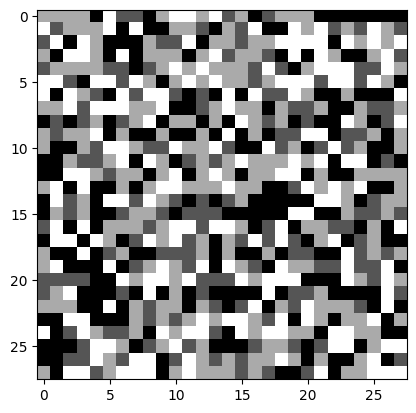

In [13]:
plt.imshow(sample.squeeze().detach().numpy(), cmap='gray')
plt.show()

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
# @title Creating DataLoader for binarised MNIST
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=32, shuffle=False)

In [15]:
model = ConditionalPixelVAE(in_channels=1,
                 latent_dim=128,
                 hidden_layers=15).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=10, gamma=0.5)
epochs = 20
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimiser, max_lr=1e-4, total_steps=epochs*len(train_loader),
    pct_start=0.1, anneal_strategy='cos', div_factor=10)

for epoch in range(epochs):
    model.train()
    epoch_reconstruction_loss, epoch_regularisation_loss = 0.0, 0.0

    for imgs, labels in tqdm(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimiser.zero_grad()

        pixel_targets = torch.clamp((imgs * 4).long(), max=3)   # used to create 4-bin mnist to [0,3] range
        mu, logvar, z, logits = model(pixel_targets.float(), labels)

        # reconstruction: sum over pixels, avg over batch
        reconstruction_loss = F.cross_entropy(logits, pixel_targets.squeeze(1))

        # KL divergence
        regularisation_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()

        loss = reconstruction_loss + regularisation_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimiser.step()

        epoch_reconstruction_loss += reconstruction_loss.item()
        epoch_regularisation_loss += regularisation_loss.item()

    scheduler.step()

    model.eval()    # calculate test loss
    running_val_loss = 0.0
    with torch.inference_mode():
        for img, label in test_loader:
            img = img.to(device)
            label = label.to(device)
            pixel_targets  = torch.clamp((img * 4).long(), max=3)   # (B,1,H,W)

            mu, logvar, z, logits = model(pixel_targets.float(), label)
            loss = F.cross_entropy(logits, pixel_targets.squeeze(1))
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(test_loader)

    print(f"Epoch {epoch+1}/{epochs} \nRecon: {epoch_reconstruction_loss/len(train_loader)}, "
          f"KL: {epoch_regularisation_loss/len(train_loader)}, Total: {(epoch_reconstruction_loss+epoch_regularisation_loss)/len(train_loader)}"
          f"Test loss: {avg_val_loss}")

100%|██████████| 1875/1875 [03:49<00:00,  8.16it/s]


Epoch 1/20 
Recon: 0.5472880179643631, KL: 0.0017333504274487496, Total: 0.5490213683918118Test loss: 0.2598460753219196


100%|██████████| 1875/1875 [03:50<00:00,  8.13it/s]


Epoch 2/20 
Recon: 0.23071139833927154, KL: 3.149995704491933e-06, Total: 0.23071454833497604Test loss: 0.21197512641120642


100%|██████████| 1875/1875 [03:50<00:00,  8.15it/s]


Epoch 3/20 
Recon: 0.2062042684475581, KL: 1.6146441300710042e-06, Total: 0.20620588309168816Test loss: 0.1977931668107121


100%|██████████| 1875/1875 [03:50<00:00,  8.13it/s]


Epoch 4/20 
Recon: 0.19532447420756022, KL: 1.4453450838724773e-06, Total: 0.19532591955264408Test loss: 0.18958742511919893


100%|██████████| 1875/1875 [03:50<00:00,  8.13it/s]


Epoch 5/20 
Recon: 0.18957957582473756, KL: 1.3471737504005433e-06, Total: 0.18958092299848794Test loss: 0.18562654503427756


100%|██████████| 1875/1875 [03:50<00:00,  8.13it/s]


Epoch 6/20 
Recon: 0.18603948655923208, KL: 1.2765288352966308e-06, Total: 0.18604076308806738Test loss: 0.18316643401837576


100%|██████████| 1875/1875 [03:50<00:00,  8.13it/s]


Epoch 7/20 
Recon: 0.18360463693936666, KL: 1.2110774715741476e-06, Total: 0.18360584801683824Test loss: 0.1810889269311588


100%|██████████| 1875/1875 [03:50<00:00,  8.13it/s]


Epoch 8/20 
Recon: 0.18177400091489157, KL: 1.1684954166412353e-06, Total: 0.1817751694103082Test loss: 0.17931947012107594


100%|██████████| 1875/1875 [03:50<00:00,  8.12it/s]


Epoch 9/20 
Recon: 0.18032067112922667, KL: 1.1353363593419394e-06, Total: 0.18032180646558602Test loss: 0.1784009018454689


100%|██████████| 1875/1875 [03:50<00:00,  8.12it/s]


Epoch 10/20 
Recon: 0.17884599049886069, KL: 1.1111795902252196e-06, Total: 0.17884710167845091Test loss: 0.17658927084538883


100%|██████████| 1875/1875 [03:50<00:00,  8.12it/s]


Epoch 11/20 
Recon: 0.17739094741344452, KL: 1.0775466759999593e-06, Total: 0.17739202496012052Test loss: 0.17551769582798687


100%|██████████| 1875/1875 [03:50<00:00,  8.13it/s]


Epoch 12/20 
Recon: 0.17640698831081392, KL: 1.0677849253018696e-06, Total: 0.1764080560957392Test loss: 0.17494767456770705


100%|██████████| 1875/1875 [03:50<00:00,  8.14it/s]


Epoch 13/20 
Recon: 0.1755021230618159, KL: 1.0494003693262735e-06, Total: 0.17550317246218522Test loss: 0.1740471024673206


100%|██████████| 1875/1875 [03:50<00:00,  8.12it/s]


Epoch 14/20 
Recon: 0.17464195812543234, KL: 1.028837263584137e-06, Total: 0.17464298696269592Test loss: 0.17380355469906292


100%|██████████| 1875/1875 [03:50<00:00,  8.12it/s]


Epoch 15/20 
Recon: 0.17395848565896352, KL: 1.02204034725825e-06, Total: 0.1739595076993108Test loss: 0.17271813821678345


100%|██████████| 1875/1875 [03:50<00:00,  8.12it/s]


Epoch 16/20 
Recon: 0.17315408058961232, KL: 1.0151808460553487e-06, Total: 0.17315509577045837Test loss: 0.17189519302532696


100%|██████████| 1875/1875 [03:50<00:00,  8.13it/s]


Epoch 17/20 
Recon: 0.17244534064133962, KL: 1.0067999362945557e-06, Total: 0.1724463474412759Test loss: 0.17143375719317233


100%|██████████| 1875/1875 [03:50<00:00,  8.13it/s]


Epoch 18/20 
Recon: 0.17165377465089163, KL: 1.0022883613904317e-06, Total: 0.17165477693925302Test loss: 0.170221743777918


100%|██████████| 1875/1875 [03:49<00:00,  8.19it/s]


Epoch 19/20 
Recon: 0.17089846772352854, KL: 9.930402040481568e-07, Total: 0.17089946076373258Test loss: 0.16999860722036025


100%|██████████| 1875/1875 [03:51<00:00,  8.11it/s]


Epoch 20/20 
Recon: 0.17019547630945842, KL: 9.882956743240357e-07, Total: 0.17019646460513274Test loss: 0.16894290531976536


In [16]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'conditional_pixelvae_4_way_model_epochs_20_v3.pth')

torch.save(optimiser.state_dict(), 'conditional_pixelvae_4_way_optimiser_epochs_20_v3.pth')

In [ ]:
# @title Sample images

model = ConditionalPixelVAE(in_channels=1,
                 latent_dim=32,
                 hidden_layers=5)  # Create an instance of your model

model.load_state_dict(torch.load('conditional_pixelvae_model_latent_32.pth')) # Load the saved state dictionary
model.to(device)

ConditionalPixelVAE(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (5): ReLU()
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
      (8): ZeroPad2d((0, 1, 0, 1))
      (9): ReLU()
      (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (11): ReLU()
      (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (13): ReLU()
      (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (15): ReLU()
      (16): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (17): ReLU()
      (18): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (19): ReLU()
      (20): Flatten(start_dim

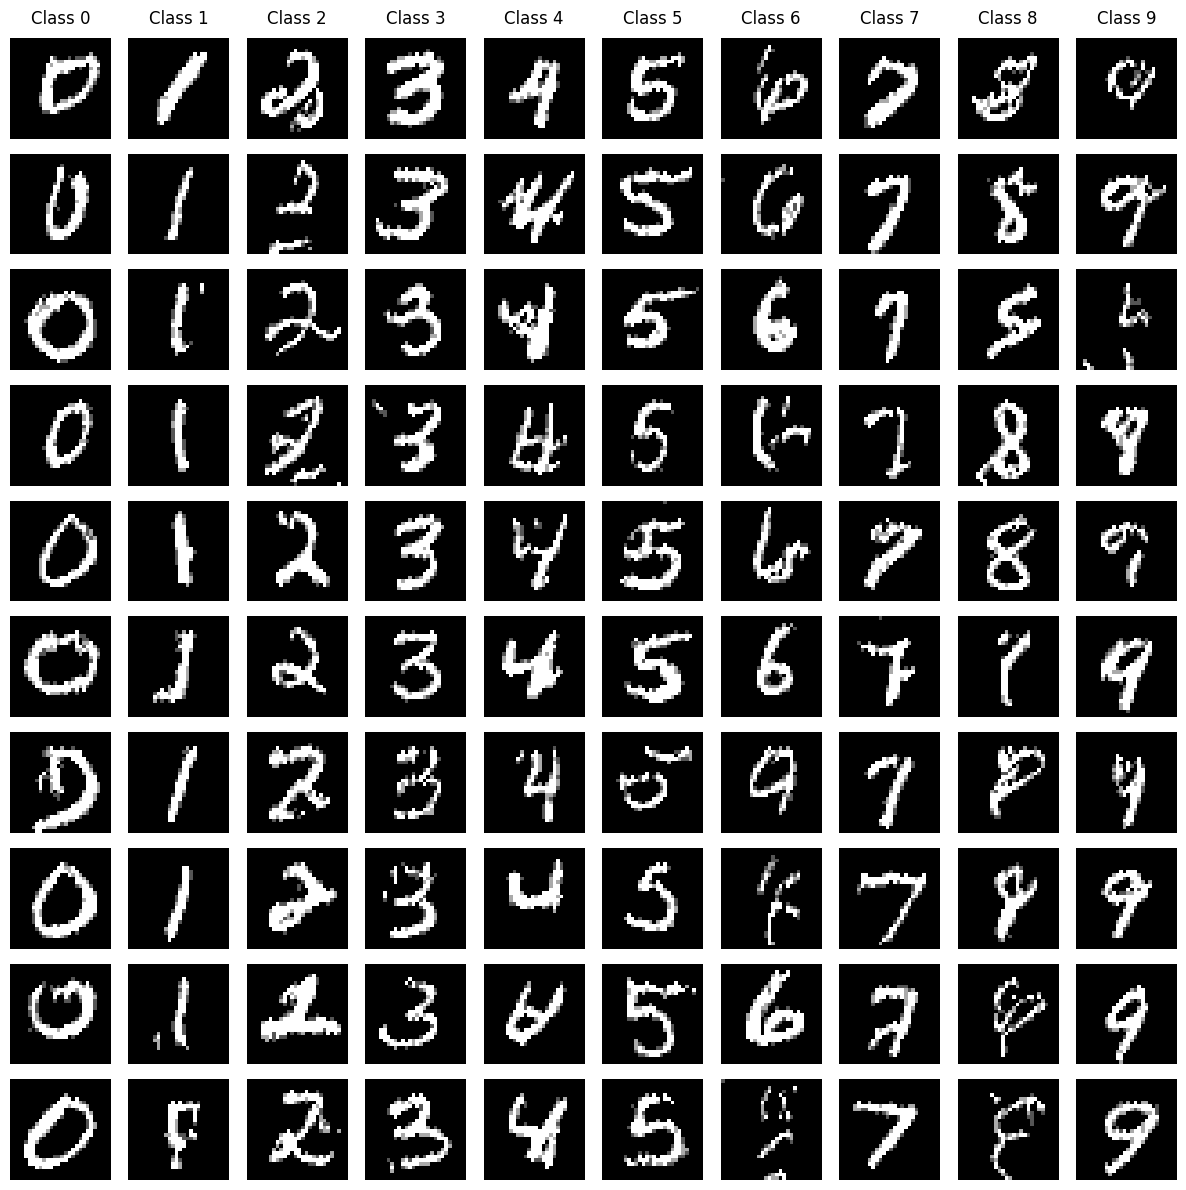

In [17]:
# @title Plot images according to class
import torch
import matplotlib.pyplot as plt

num_classes = 10
num_samples_per_class = 10

generated_images = []
for class_label in range(num_classes):
    class_images = model.sample(    # use sample function
        image_size=(28, 28),
        num_samples=num_samples_per_class,
        labels=torch.full((num_samples_per_class,), class_label, dtype=torch.long),
        device=device
    )
    generated_images.append(class_images)

fig, axes = plt.subplots(num_samples_per_class, num_classes, figsize=(12, 12))

for col in range(num_classes):
    for row in range(num_samples_per_class):
        ax = axes[row, col]
        img = generated_images[col][row].squeeze().cpu().numpy()
        ax.imshow(img, cmap="gray")
        ax.axis("off")

    axes[0, col].set_title(f"Class {col}", size='large', pad=10)

plt.tight_layout()
plt.show()

In [18]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

+------------------------------------------------------------+------------+
|                          Modules                           | Parameters |
+------------------------------------------------------------+------------+
|                    encoder.net.0.weight                    |    288     |
|                     encoder.net.0.bias                     |     32     |
|                    encoder.net.2.weight                    |    9216    |
|                     encoder.net.2.bias                     |     32     |
|                    encoder.net.4.weight                    |    9216    |
|                     encoder.net.4.bias                     |     32     |
|                    encoder.net.6.weight                    |   18432    |
|                     encoder.net.6.bias                     |     64     |
|                   encoder.net.10.weight                    |   36864    |
|                    encoder.net.10.bias                     |     64     |
|           

13065102

In [20]:
import math
import torch
import torch.nn as nn

def compute_bits_per_dim(model, data_loader, device):
    criterion = nn.CrossEntropyLoss(reduction='sum')
    model.eval()
    total_loss = 0.0
    total_elements = 0
    with torch.inference_mode():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            batch_size = imgs.shape[0]
        
            num_pixels = imgs.shape[2] * imgs.shape[3]

            pixel_targets = torch.clamp((imgs * 4).long(), max=3)
            _, _, _, output = model(pixel_targets.float(), labels)
            
        
            loss = criterion(output, pixel_targets.squeeze(1))
            total_loss += loss.item()
            total_elements += batch_size * num_pixels


    average_nll = total_loss / total_elements

    bits_per_dim = average_nll / math.log(2)
    return average_nll, bits_per_dim

average_nll, bits_dim = compute_bits_per_dim(model, test_loader, device)
print(f"Average NLL (nats per pixel): {average_nll}")
print(f"Bits per dim: {bits_dim}")

Average NLL (nats per pixel): 0.1690034806543467
Bits per dim: 0.24382048343299986
